# The most characteristic words in pro- and anti-feminist tweets #

## Attitude analysis by machine learning as an alternative to sentiment analysis in order to classify tweets as pro- or anti-feminist, and determine the differences in their vocabularies ##

#### This project won the Data Science prize andthe  NLP prize at the Montreal Big Data Week Hackathon 2015 #

By David Taylor, Zafarali Ahmed, Jerome Boisvert-Chouinard, Dave Gurnsey, Nancy Lin, and Reda Lotfi

For a blog post about the results: http://www.prooffreader.com

For a blog post about the methodology: http://prooffreaderplus.blogspot.ca

---

OUTLINE:

* We used the Twitter Search API from January to April, 2015 to search twitter periodically (at random intervals as short as 15 minutes) for the last tweets containing the terms 'feminist', 'feminists' and 'feminism' (usually the last 100 tweets, but at random intervals once every few days, the last 1500 tweets). 
* A CSV file was made of the search results resulting in about 988,000 tweets. Retweets and duplicate tweets (i.e. coming from a 'share this' button on a website) were removed, with the justification that we are studying the words humans choose to actively employ in tweets; simply clicking a button to retweet or share does not involve authorial word choice on the part of the tweeter.
* We manually curated approximately 1,000 randomly chosen tweets into the following three categories: 'pro-feminist' (1), 'anti-feminist' (-1), 'neither' (0). This involved some reflection, to try to intuit the underlying attitude of the tweet's author. When in doubt, for example if the tweet was news reporting or if it may have been sarcastic, we defaulted to class 0.
* We tokenized the tweets (broke them up into separate words and symbols) with almost no stopwords, with the justification that in only 140 characters, every token matters.
* We verified that sentiment analysis was not up to the task of predicting our attitude classes, so we used a Naive Bayes classifier to predict the attitudes of the other 390,000 tweets.
* We used the log-likelihood method to determine which words or tokens were most characteristic ('key') to each of the pro- or anti-feminist (+1 or -1) attitude classes.

---
Import libraries

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
import shutil
import time
import urllib.request

from collections import Counter
from textblob import TextBlob

%matplotlib inline

### Download data

The data set was too huge to host on GitHub, so we hosted it on David Taylor's professional website, dtdata.io, along with the manually curated dataset. The full dataset is 248 Mb. It will not be downloaded if it already exists in your working directory, unless you change ``overwrite`` to ``True``.

In [2]:
overwrite = False # change to true to overwrite existing files

for url in ['http://www.dtdata.io/femtwitr/twitter_feminism_201501_201504.csv', 
            'http://www.dtdata.io/femtwitr/curated_feminism_tweets.csv']:
    file_name = os.path.split(url)[1]
    if (not os.path.isfile(file_name) or overwrite == True):
        with urllib.request.urlopen(url) as response, open(file_name, 'wb+') as out_file:
            shutil.copyfileobj(response, out_file)

### See whether sentiment analysis can be used as a predicter of attitude. #

Sentiment analysis relies on identifying 'positive' or 'negative' words (e.g. 'love', 'awesome'; 'hate', 'sucks'). This does not translate into attitude analysis simply because support for or opposition to a position can be done with both positive- and negative-sentiment words. For example:

    "I don't like feminists"                        sentiment=negative  attitude=anti-feminist
    "I don't like people questioning my feminism"   sentiment=negative  attitude=pro-feminist
    
A well-known out-of-the-box sentiment analyzer is that of the ``patterns`` library, in this case wrapped in the ``textblob`` library.

First, let's load the curated tweets and see how many there are in each category. We'll use a pie chart, even though it's frowned upon in many circles, because it's universally understood. Since the tweets to curate were randomly chosen, the relative sizes of these categories should reflect those in the entire dataset.

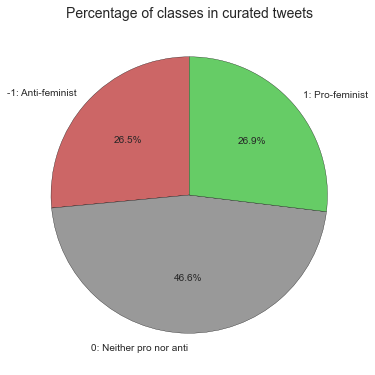

In [3]:
# load curated tweets into dataframe
df_curated = pd.read_csv('curated_feminism_tweets.csv', encoding='latin-1', index_col=None)
# ensure all tweets are classified
assert len(df_curated) == len(df_curated[df_curated['class'].isin([0,1,-1])])
# get rid of any non-information-carrying columns (e.g. 'index' created from parsing)
df_curated = df_curated[['id', 'tweet', 'class']]

plt.figure(1, figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])
labels = '-1: Anti-feminist', '0: Neither pro nor anti', '1: Pro-feminist'
fracs = [len(df_curated[df_curated['class'] == -1]) / len(df_curated),
         len(df_curated[df_curated['class'] == 0]) / len(df_curated),
         len(df_curated[df_curated['class'] == 1]) / len(df_curated)]
plt.pie(fracs, labels=labels,
        colors = ['#cc6666', '#999999', '#66cc66'],
        autopct='%1.1f%%', startangle=90)
plt.title('Percentage of classes in curated tweets', fontsize=14)
plt.show()

Unfortunately, the Twitter Search app and python script we used did not parse unicode characters correctly (it renders unicode character ``\u2018`` as those six characters instead of an opening smart single quote, for example), so we'll change some of the more common ones (smart single and double quotes, en dash, and an emoji) to proper unicode.

In [4]:
unicode_replacements = (('\\u2018', '\u2018'), ('\\u2019', '\u2019'),
                        ('\\u201c', '\u201c'), ('\\u201d', '\u201d'),
                        ('\\U0001f602', 'u0001f602'), ('\\u2013', '\u2013'),
                        ('\\xe9', 'é'), ('\\x93', ' '), ('\\x94', ' '),
                        ('\\ufe0f', ' '), ('|', ' '))
def fix_unicode(cell):
    fixed = cell
    for before, after in unicode_replacements:
        fixed = fixed.replace(before, after)
        fixed = re.sub('http://t.co[^ ]+', 'http://t.co/etc.', fixed)
    return fixed
        
df_curated['tweet_after'] = df_curated.tweet.apply(fix_unicode)

print('{} out of {} tweets now have improperly escaped unicode characters.'.format(
        len(df_curated[df_curated.tweet.str.contains('\\\\u')]), len(df_curated)))

_ = len(df_curated)
df_curated.drop_duplicates(subset=['tweet'], inplace=True)
print('{} duplicate tweets dropped'.format(_ - len(df_curated)))

129 out of 947 tweets now have improperly escaped unicode characters.
44 duplicate tweets dropped


Now we'll test automated sentiment analysis, which is based on a corpus of movie reviews. It gives a score of -1 to +1 for polarity and 0 to 1 for subjectivity, so we'll add those two columns to ``df_curated`` and plot them on a graph to see if they are separable.

In [5]:
def assign_polarity(cell):
    return TextBlob(cell).polarity
df_curated['polarity'] = df_curated.tweet.apply(assign_polarity)
def assign_subjectivity(cell):
    return TextBlob(cell).subjectivity
df_curated['subjectivity'] = df_curated.tweet.apply(assign_subjectivity)

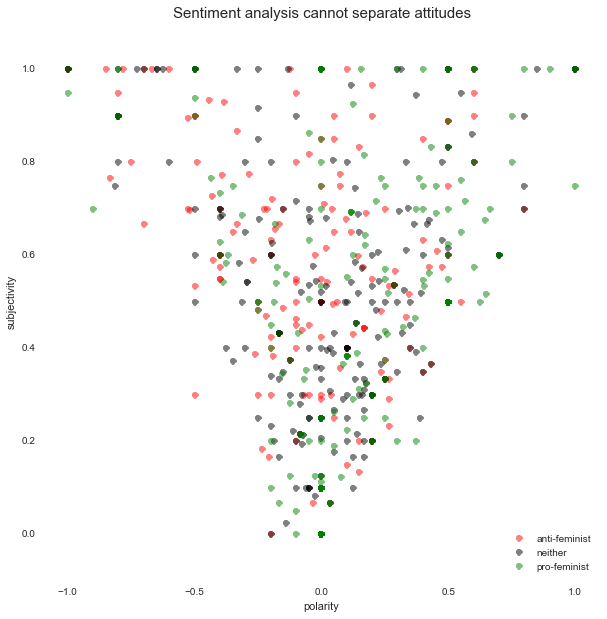

In [6]:
plt.figure(figsize=(10,10))
#plt.subplot(3,1,1)
plt.xlim(-1.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xlabel('polarity')
plt.ylabel('subjectivity')
_1 = df_curated[df_curated['class'] == -1]
plt.plot(_1.polarity, _1.subjectivity, 'ro', alpha = 0.5, label='anti-feminist')
#plt.subplot(3,2,1)
_2 = df_curated[df_curated['class'] == 0]
plt.plot(_2.polarity, _2.subjectivity, 'ko', alpha = 0.5, label='neither')
#plt.subplot(3,3,1)
_3 = df_curated[df_curated['class'] == 1]
plt.plot(_3.polarity, _3.subjectivity, 'go', alpha = 0.5, label='pro-feminist')
plt.legend(loc=4)
plt.title('Sentiment analysis cannot separate attitudes', fontsize=15)
plt.show()


# df_ = df_curated[df_curated['class'] == 0]
# g = sns.jointplot(df_.polarity, df_.subjectivity, kind="kde", size=7, space=0)

There are not many obvious ways from the above graph to predict attitude based on polarity and subjectivity; none of the classes is very separable from the others.

A random forest classifier based on polarity and subjectivity does not do a great job at predicting classes -1 and +1, although it does better predicting class 0 -- the one we are not interested in. Look at the accuracy below; random choice with three categories would have a success rate of 33%.

We also calculate the 'precision' and 'recall' of each class, which are, respectively, the % of those predicted to be in the class (true positives + false positives) that are actually in the class (true positives), and the % of all of those that are actually in the class (true positives + false negatives) that were predicted to be in the class (true positives). (Precision and recall can be a little mindbending at first, but eventually you get used to them).

In [7]:
from sklearn.ensemble import RandomForestClassifier
df_curated['is_train'] = np.random.uniform(0, 1, len(df_curated)) <= .75 # randomly assign training and testing set
train, test = df_curated[df_curated['is_train']==True], df_curated[df_curated['is_train']==False]
features = ['polarity', 'subjectivity']
y = np.array(train['class'])
clf = RandomForestClassifier(n_jobs=2)
clf = clf.fit(train[features], y)

predicted = clf.predict(test[features])
train_predicted = clf.predict(train[features])
test_result = pd.crosstab(test['class'], predicted,
                      rownames=['actual'], colnames=['predicted'])
total_correct = test_result.loc[-1,-1] + test_result.loc[0,0] + test_result.loc[1,1]
train_result = pd.crosstab(train['class'], train_predicted,
                      rownames=['actual'], colnames=['predicted'])
train_total_correct = train_result.loc[-1,-1] + train_result.loc[0,0] + train_result.loc[1,1]
print("Confusion matrix:")
print("")
print("Classes:")
print("        predicted")
print(test_result)
print('')
print('Total test set accuracy is {}+{}+{}={} / {} = {}%'.format(
        test_result.loc[-1,-1], test_result.loc[0,0], test_result.loc[1,1],
        total_correct, len(test), round(100*total_correct/len(test), 1)))
print('Total training set accuracy is {}+{}+{}={} / {} = {}%'.format(
        train_result.loc[-1,-1], train_result.loc[0,0], train_result.loc[1,1],
        train_total_correct, len(train), round(100*train_total_correct/len(train), 1)))
print('')
print('Class  Precision  Recall')
for i in [-1, -0, 1]:
    print('{:2d}     {:2.1f}%      {:2.1f}%'.format(i, 
        100*test_result.loc[i,i] / test_result.loc[i,:].sum(),
        100*test_result.loc[i,i] / test_result.loc[:,i].sum()))

Confusion matrix:

Classes:
        predicted
predicted  -1   0   1
actual               
-1         15  25  11
 0         19  64  18
 1         12  30  11

Total test set accuracy is 15+64+11=90 / 205 = 43.9%
Total training set accuracy is 112+296+99=507 / 698 = 72.6%

Class  Precision  Recall
-1     29.4%      32.6%
 0     63.4%      53.8%
 1     20.8%      27.5%


### Load full tweet dataset and eliminate retweets and duplicates

In [8]:
df = pd.read_csv('twitter_feminism_201501_201504.csv', encoding='latin-1')
df.drop('Unnamed: 0', axis=1, inplace=True) # drop garbage duplicate index column
len_1 = len(df)
df = df[~(df.tweet.str.contains('^RT '))]
len_2 = len(df)
df['tweet'] = df.tweet.apply(fix_unicode) # apply the same unicode fixer as above
df.drop_duplicates(subset='tweet', inplace=True)
print('{} tweets loaded\n{} tweets after eliminating retweets\n{} tweets after eliminating duplicate tweets'.format(
        len_1, len_2, len(df)))

985633 tweets loaded
395690 tweets after eliminating retweets
355736 tweets after eliminating duplicate tweets


Let's have a look at the dataset.

In [9]:
df.tail()

,term,id,tweet,return_num,total_num,db_entered_time,tweeted_time,followers,reply_id,favorite_count,retweet_count,retweeted,user_location_text,statuses_count,utc_offset,account_created
985613,feminism,590974109342924800,"Yotubazos:""Trigger warnings demean feminism. H...",79,100,2015-04-22 20:28:55,2015-04-22 20:23:02,709,0,0,0,0,Colombia,75350,NaN,2014-10-05 11:08:05
985616,feminism,590974068708536321,Hillary Clinton and Corporate Feminism Solid...,83,100,2015-04-22 20:28:55,2015-04-22 20:22:52,438,0,0,0,0,"Lowell, MA",11587,NaN,2010-09-08 00:31:32
985617,feminism,590974038060630016,"Feminism is a beautiful ideology, it is now ca...",85,100,2015-04-22 20:28:56,2015-04-22 20:22:45,43,0,0,0,0,"Kent, OH",277,NaN,2014-05-31 15:21:09
985621,feminism,590973925254762496,"@Awyee707 @TigerClaud Paraphrasing ""If social ...",89,100,2015-04-22 20:28:56,2015-04-22 20:22:18,47,590973447645204480,0,0,0,NaN,1112,NaN,2015-03-25 04:32:42
985625,feminism,590973880954703872,@amyschumer needs to learn to #Feminism you in...,93,100,2015-04-22 20:28:57,2015-04-22 20:22:07,1143,0,0,0,0,New Eggland,10549,-18000,2014-10-15 04:01:25


Description of features:
    
    term               The search term, 'feminism', 'feminist' or 'feminists'
    id                 Unique ID for the tweet, e.g.
    tweet              TEXT OF THE TWEET
    return_num         Position during the search, 1, 2, 3... the larger this number, 
                       the older the tweet was
    total_num          Total number of records retrieved during that search; usually 100, 
                       but every now and then at random intervals I returned as many records
                       as possible during the search; because I was lazy, I didn't record
                       the actual number (about 16,000) but put 99999.
    db_entered_time    string, e.g. '2015-01-16 20:53:13'; all times are UTC
    tweeted_time       string, e.g. '2015-01-16 20:52:46'
    followers          how many followers that tweeter has
    reply_id           If this tweet is a reply to a previous tweet, the ID of that tweet
    retweet_count      If this is a retweet, how many times this tweet was retweeted 
                       before this retweet
    retweeted          How many times this tweet was retweeted between its creation and 
                       its search in the database. For this dataset, it is always zero 
                       (i.e. we're always searching the tweet too soon after its creation
                       to pick up retweets. For rarer search terms, this can be non-zero).
    user_location_text A user-entered string describing their location, usually of limited 
                       utility due to entries like "A galaxy far, far away"
    statuses_count     How many statuses (e.g. not retweets) this tweeter made before 
                       this tweet.
    utc_offset         How many hours away from UTC the user is; a useful measure of 
                       longitude. e.g. -18000
    account_created    string, 2009-12-29 21:51:10

Custom tweet tokenizer, adapted from http://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/

In [10]:
## words
regex_str = [
  r'<[^>]+>', # HTML tags
  r'(?:@[\w_]+)', # @-mentions
  r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
  r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

  r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
  r"(?:[a-z][a-z'\u2019_]+[a-z])", # words with -, ' or curly apostrophe
  r'(?:[\w_]+)', # other words
  r'(?:\S)' # anything else
]

## compile regex
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)

def tokenize(string):
    return tokens_re.findall(string)
def removable(token):
    return token in [',', '.', ':', ';']
def pre_process(string, lowercase=True):
    tokens = tokenize(string)
    if lowercase:
        tokens = [ token.lower() for token in tokens if not removable(token)]
    else:
        tokens = [ token for token in tokens if not removable(token)]
    return tokens

An example of the tokenizer in action

In [11]:
example = ( "\"Don't\" with straight quotes and apostrophe, \u201cdon\u2019t\u201d with curly quotes and apostrophe. "
            "\\u2013 unrecognized unicode; hyphenated-words; @mention: #hashtag -- http://a.url words>separated?by.things, "
            "3.1415 numbers alone" )

print(pre_process(example))

['"', "don't", '"', 'with', 'straight', 'quotes', 'and', 'apostrophe', '“', 'don’t', '”', 'with', 'curly', 'quotes', 'and', 'apostrophe', '\\', 'u2013', 'unrecognized', 'unicode', 'hyphenated', '-', 'words', '@mention', '#hashtag', '-', '-', 'http://a.url', 'words', '>', 'separated', '?', 'by', 'things', '3.1415', 'numbers', 'alone']


## Tokenize, vectorize, and classify

Tokenize and vectorize curated tweets (for 'bag-of-words' features) and train a Naive Bayes classifier to classify the remaining 390,000 tweets as class +1, 0, or -1.

In [12]:
#randomize order of rows
df_curated.reset_index(drop=True, inplace=True)
df_curated.reindex(np.random.permutation(df_curated.index))
#take a 75% training set
train_size = int(len(df_curated) * .75)
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(tokenizer=pre_process)
bagofwords = vec.fit_transform(df_curated.tweet)
bagofwords = bagofwords.toarray()
train = bagofwords[:train_size,:]
test = bagofwords[train_size:,:]
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=0.7).fit(train, df_curated[:train_size]['class'])

predicted = clf.predict(test)
train_predicted = clf.predict(train)
test_result = pd.crosstab(df_curated[train_size:]['class'], predicted,
                      rownames=['actual'], colnames=['predicted'])
total_correct = test_result.loc[-1,-1] + test_result.loc[0,0] + test_result.loc[1,1]
train_result = pd.crosstab(df_curated[:train_size]['class'], train_predicted,
                      rownames=['actual'], colnames=['predicted'])
train_total_correct = train_result.loc[-1,-1] + train_result.loc[0,0] + train_result.loc[1,1]
print("Confusion matrix:")
print("")
print("Classes:")
print("        predicted")
print(test_result)
print('')
print('Total test set accuracy is {}+{}+{}={} / {} = {}%'.format(
        test_result.loc[-1,-1], test_result.loc[0,0], test_result.loc[1,1],
        total_correct, len(test), round(100*total_correct/len(test), 1)))
print('Total train set accuracy is {}+{}+{}={} / {} = {}%'.format(
        train_result.loc[-1,-1], train_result.loc[0,0], train_result.loc[1,1],
        train_total_correct, len(train), round(100*train_total_correct/len(train), 1)))
print('')
print('Class  Precision  Recall')
for i in [-1, -0, 1]:
    print('{:2d}     {:2.1f}%      {:2.1f}%'.format(i, 
        100*test_result.loc[i,i] / test_result.loc[i,:].sum(),
        100*test_result.loc[i,i] / test_result.loc[:,i].sum()))

Confusion matrix:

Classes:
        predicted
predicted  -1   0   1
actual               
-1         28   4  13
 0         45  36  29
 1         29   6  36

Total test set accuracy is 28+36+36=100 / 226 = 44.2%
Total train set accuracy is 191+269+165=625 / 677 = 92.3%

Class  Precision  Recall
-1     62.2%      27.5%
 0     32.7%      78.3%
 1     50.7%      46.2%


Our test set accuracy is comparable to the Random Forest based on sentiment, but it is much better at predicting classes -1 and +1, at the expense of class 0, which we don't care about. In addition, our precision is way up, which we care about more than recall (i.e. we want the true posives to be correctly classified, we don't care as much whether the correctly classified are true positives... this actually makes sense, we promise!) We're overfitting, given the huge gap between test set and training set accuracy -- the obvious solution for a future implementation is to manually curate some more tweets, or do dimensionality reduction on the bag-of-words vectors

In [13]:
%%time

# add the predicted class to the 390,000-tweet dataframe
bagofwords = vec.fit(df_curated.tweet)
df_vector = bagofwords.transform(df.tweet)
df['class'] = clf.predict(df_vector)

Wall time: 17.9 s


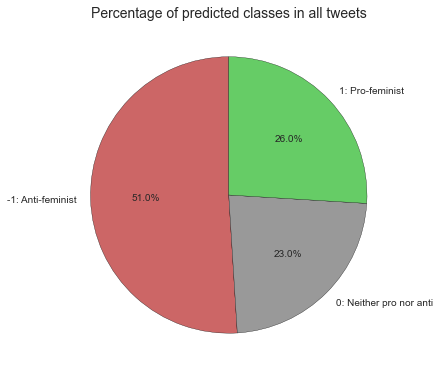

In [14]:
plt.figure(1, figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])
labels = '-1: Anti-feminist', '0: Neither pro nor anti', '1: Pro-feminist'
fracs = [len(df[df['class'] == -1]) / len(df),
         len(df[df['class'] == 0]) / len(df),
         len(df[df['class'] == 1]) / len(df)]
plt.pie(fracs, labels=labels,
        colors = ['#cc6666', '#999999', '#66cc66'],
        autopct='%1.1f%%', startangle=90)
plt.title('Percentage of predicted classes in all tweets', fontsize=14)
plt.show()

As you can see, we're overfitting; a lot of tweets are being classified as anti-feminist. However, once we do the log-likelihood method, words that truly do not differ between the two classes should cancel out; we should be safe as long as we draw inferences only from words with very high or low log-likelihood values.

## Calculate token frequencies for each class

In [15]:
# This is a rudimentary progress 'bar' (more of a counter) ... it's nice 
# when sharing notebooks after they're run, because you never know how 
# widget-based graphic bars will display, and this shows you that the
# function was indeed run all the way and how long it took.

class ProgressBar: 
    """ Init with loop_length, i.e. number of events that add up to 100%, then use methods
    .increment() for each event, and .finish() when complete. """
    def __init__(self, loop_length):
        import time
        self.start = time.time()
        self.increment_size = 100.0/loop_length
        self.curr_count = 0
        self.curr_pct = 0
        self.overflow = False
        print('% complete:', end=' ')
    def increment(self):
        self.curr_count += self.increment_size
        if int(self.curr_count) > self.curr_pct:
            self.curr_pct = int(self.curr_count)
            if self.curr_pct <= 100:
                print (self.curr_pct, end=' ')
            elif self.overflow == False:
                print("\n*!* Count has gone over 100%; likely either due to:\n*!*   - an error in the loop_length specified when " + \
                      "progress_bar was instantiated\n*!*   - an error in the placement of the increment() function")
                print('*!* Elapsed time when progress bar full: %0.1f seconds.' % (time.time() - self.start))
                self.overflow = True
    def finish(self):
        if self.curr_pct == 99:
            print("100"), # this is a cheat, because rounding sometimes makes the maximum count 99. One day I'll fix this bug.
        if self.overflow == True:
            print('*!* Elapsed time after end of loop: %0.1f seconds.\n' % (time.time() - self.start))
        else:
            print('\nElapsed time: %0.1f seconds.\n' % (time.time() - self.start))
            


We go through all of the approximately 300,000 tweets classified as pro- or anti-feminist, and calculate the frequency of tokens in each class.

In [16]:
pbar = ProgressBar(len(df[df['class'] != 0]))

token_collector = []
frequency_collector = []
class_collector = []
    
for class_ in [-1, 1]:
    df_ = df[df['class'] == class_]
    c = Counter()
    for key, row in df_.iterrows():
        terms = [ term for term in pre_process( row['tweet'] ) ]
        c.update(terms)
        pbar.increment()
    for token, frequency in c.items():
        token_collector.append(token)
        frequency_collector.append(frequency)
        class_collector.append(class_)
pbar.finish()
df_freqs = pd.DataFrame({'token':token_collector, 'freq': frequency_collector, 'class': class_collector })

% complete: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Elapsed time: 37.5 seconds.



For fun, let's look at the top 10 tokens in each class, although raw numbers aren't that informative; we'll see a lot of stopwords. The log-likelihood results will be much more interesting

In [17]:
print('pro-feminist:', [x for x in list(df_freqs[df_freqs['class'] == 1].sort('freq', ascending=False).token[:10])])
print('anti-feminist:', [x for x in list(df_freqs[df_freqs['class'] == -1].sort('freq', ascending=False).token[:10])])

pro-feminist: ['feminism', 'is', 'a', 'the', 'i', 'to', 'and', 'http://t.co/etc.', 'of', 'for']
anti-feminist: ['the', 'feminism', 'a', 'feminists', 'to', '?', '"', 'i', 'is', 'and']


## Calculate log-likelihood of each token

Now we calculate the log-likelihood of each word being characteristic of one class or another. Log-likelihood is a measure of significance, so it's essentially a transformed p-value. A good way to think of it is, you've got words in class -1 and in class +1. The 'significance' is a measure of how 'surprised' would you be to have at least as unequal a distribution of that word between the classes if the classes had been randomly assigned.

The nice thing about log-likelihood is that it takes into account both the ratio and the absolute values of the frequencies. In other words, if "goldilocks" (to pick a word totally at random) appeared 10 times in the anti-feminist tweets and 20 times in the pro-feminist tweets, it would have a lower log-likelihood than if it appeared 100 times and 200 times, respectively, even though the ratio between them is the same. How much lower depends on the total size of the dataset; we're more 'surprised' to find differences in randomly-classified words in large datasets than in small ones.

In [18]:
def calc_loglikelihood(n1, t1, n2, t2):
    """Calculates Dunning log likelihood of an observation of 
    frequency n1 in a corpus of size t1, compared to a frequency n2 
    in a corpus of size t2. If result is positive, it is more 
    likely to occur in corpus 1, otherwise in corpus 2."""
    from numpy import log
    e1 = t1*1.0*(n1+n2)/(t1+t2) # expected values
    e2 = t2*1.0*(n1+n2)/(t1+t2)
    result = 2 * ((n1 * log(n1/e1)) + n2 * (log(n2/e2)))
    if n2*1.0/t2 > n1*1.0/t1:
        result = -result
    return result

cutoff = 10 # to save time and since low-frequency words have low log-likelihoods anyway,
            # we specify that a word has to appear this many times in both classes.

t1 = df_freqs[df_freqs['class'] == 1].freq.sum()
t2 = df_freqs[df_freqs['class'] == -1].freq.sum()
token_collector = []
loglikelihood_collector = []
df_freqs = df_freqs[df_freqs.freq >= cutoff]
pbar = ProgressBar(len(df_freqs.token.unique()))
for token in df_freqs.token.unique():
    pbar.increment()
    try:
        n1 = df_freqs[(df_freqs['class'] == 1) & (df_freqs.token == token)].freq.iloc[0]
    except:
        n1 = 0
    try:
        n2 = df_freqs[(df_freqs['class'] == -1) & (df_freqs.token == token)].freq.iloc[0]
    except:
        n2 = 0
    if n1 > cutoff and n2 > cutoff:
        token_collector.append(token)
        loglikelihood_collector.append(calc_loglikelihood(n1, t1, n2, t2))
pbar.finish()
df_result = pd.DataFrame({'token': token_collector, 'loglikelihood': loglikelihood_collector})

% complete: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Elapsed time: 185.0 seconds.



In [19]:
df_result.sort('loglikelihood', inplace=True)
df_result.to_csv('loglikelihoods.csv')

### Here are the top 50 most characteristic tokens in anti-feminist tweets... ###

Note that the search terms, 'feminist', 'feminism' and 'feminists', will have exaggerated log-likelihoods because of selection bias.

The untranslated unicode characters ``u0001f602`` is the ``:joy:`` emoji, laughing and crying at the same time

In [20]:
print(df_result.head(50))

      loglikelihood           token
3966  -15650.641428       feminists
1903  -10213.968707               ?
1797   -3376.548563             can
981    -3043.708977            they
1377   -3012.925478               "
4672   -2931.789279               !
3464   -2645.925293           their
4206   -2496.213290             too
259    -2469.306300            with
5241   -2450.894044            want
5103   -2173.363771         twitter
4644   -1926.231007              be
4983   -1733.700388            fuck
368    -1698.972989             lol
55     -1391.352690              do
3962   -1303.057794              it
187    -1228.141965            look
3513   -1126.100667            even
1000   -1076.700139            take
3289   -1074.132993            hate
1799   -1000.977010             was
4772    -945.125945            wave
3230    -942.147421          modern
2445    -940.447069             now
5478    -935.530347             are
3423    -926.730402               2
4506    -924.831755         

### ... and the top 50 most characteristic tokens in pro-feminist tweets. ###

In [21]:
print(df_result.sort('loglikelihood', ascending=False).head(50))

      loglikelihood             token
3075    9013.374146          feminism
2897    6331.742137          equality
5734    5844.360099             about
1163    4122.174620               for
5910    3569.099648           support
4373    2651.872524                is
472     2406.301143            gender
4324    2336.542156              love
3792    2321.606868             sexes
1103    2157.852684  http://t.co/etc.
4105    1899.529532            rights
3303    1885.145615           genders
5817    1885.121293           talking
2729    1801.966029         #feminism
2093    1797.091898              need
4152    1585.478677           believe
82      1558.833426               new
4455    1486.329703            social
3548    1397.593495             equal
3265    1313.356558         #feminist
547     1225.531456               via
6116    1187.311892                 +
4232    1168.770405                 =
3278    1120.908223         political
6227    1118.560219                 i
2096    1109

## A function to give examples of tokens in tweets and their classes

Obviously, we'll see some misclassified tweets, but hopefully in the minority.

In [22]:
%%time

# Build a smaller dataframe with a tokenized column to search through faster

df_2search = df[['id', 'class', 'tweet']]
def re_tokenize(row):
    lst = pre_process(row.tweet)
    return(' '.join(lst))
df_2search['tokens'] = df_2search.apply(re_tokenize, axis=1)

# This function prints 10 randomly chosen tweets containing a specified token, and their classes.

def search_tweets(token):
    df1_ = df_2search[df_2search.tokens.str.contains('^'+token+' ')]
    df2_ = df_2search[df_2search.tokens.str.contains(' '+token+' ')]
    df3_ = df_2search[df_2search.tokens.str.contains(' '+token+'$')]
    df_ = pd.concat([df1_,df2_,df3_])
    df_.reset_index(drop=True, inplace=True)
    df_.reindex(np.random.permutation(df_.index))
    for i in range(10):
        print('{:2} {}'.format(df_['class'].iloc[i], df_.tweet.iloc[i]))

Wall time: 23.1 s


C:\Users\David\Anaconda3\envs\current\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
#first a pro-feminist word:
search_tweets('equality')

 1 equality is not present between genders. a feminist fights to change that. plain and simple.
-1 equality for all should be something that we have in society, but being a 'feminist' or a 'meninist' doesn't mean that you can use it
 1 Equality=/=justice. Being a feminist without challenging patriarchy is....pointless.
-1 Equality is cool and all but these twitter feminist activists are getting real annoying real quick.
 1 equality", then fucking fight for gender equality, and stop harassing those who use the word "feminist" online.
 1 Equality, not superiority  #meninist #meninism  #feminist #feminism http://t.co/etc.
-1 Equality @Iam_UT: How does feminism relate to her outfit ? “@Lloyd_Oski: Feminists slowly creeping into Nigeria smh.. http://t.co/etc.
-1 Equality can't be achieved if you give special treatment to anyone. I am looking at you, Feminists #antifeminism #NoToFemiBigots
 1 Equality, feminists. Equality.
 1 Equality is cool and I respect opinions, but some feminists today 

In [24]:
#now an anti-feminist word:
search_tweets('can')

-1 Can the legacy of #MalcolmX be read as feminist/womanist?  @ebonithoughts and Terrence L. Johnson seem to disagree in http://t.co/etc.
-1 Can someone explain the difference between a meninist, and a feminist. Because both are sounding EXACTLY the same to me.. #neverendingfight
-1 Can @CHSommers please confirm for me if 3rd-wave feminism considers the mother of 2nd-wave feminism anti-feminist?
-1 can i contact my local feminist representative? can i speak to a feminist labor leader?
-1 Can I just say I hate this entire 'you're not a feminist if you don't like this girl'
-1 CAN WE TALK ABOUT HOW MUCH OF A FEMINIST ICON KURT WAS
-1 Can I be a male feminist
-1 Can you give me your personal definition of a feminist? I can't get over it\U0001f605 @PIXIECRISTIN
-1 Can one be a both a feminist and a meninist? Might there a word for such an advanced thing?
-1 Can a #feminist answer this. What is it that you really try to obtain? What is your definition of equality.


In [25]:
# now let's find a term that is not characteristic of either class...
df_result[df_result.loglikelihood > 0].iloc[0]

loglikelihood    1.000875e-05
token                     add
Name: 6099, dtype: object

In [26]:
# ... and search for it. These kinds of words might have a higher rate of misclassification.
search_tweets('add')

 1 Add @haleshannon, @gailcarriger, and @benhatke to your feminist books for young readers lists: http://t.co/etc. http://t.co/etc.
-1 Add state legislation introduced by the GOP requiring women to undergo completely unnecessary, forced ultrasounds... http://t.co/etc.
-1 Add the Glosswitch person to my earlier tweet re 'feminists' who pick and choose which women are worthy of equality.
-1 Add your name to the letter to The Guardian newspaper against the No Platforming of radical feminists in Britain: http://t.co/etc.
-1 add "and women" to the constitution!! oh but don't change it from feminism to gender egalitarian, that's sexist.
 0 Add a touch of Feminism & Glamour by 0.25 ct Designer #Diamond Ring - http://t.co/etc. http://t.co/etc.
 1 add fashion along with Kylie Jenner and feminism to the list of things she doesn't know about http://t.co/etc.
 1 Add an orange to the seder plate, symbol of support for equality of women and LGBTQ+ in Judaism.  #LGBT #passover #feminism
 1 Add Just t

It would be interesting to check the misclassification rates of words with different log-likelihoods, but we would probably need a larger training set for that. Of the 1,000 curated tweets, relatively few would contain each word.